In [2]:
# Mounting the drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [4]:
sales_df=pd.read_csv('/content/drive/My Drive/Extra_files_folders/Datasets/AI in Marketing Dataset/sales_data_sample.csv', encoding='unicode_escape')

In [5]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,Ships,54,S72_3212,"Oulu Toy Supplies, Inc.",981-443655,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,Ships,54,S72_3212,Alpha Cognac,61.77.6555,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [6]:
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [7]:
# Converting the date to the date time format using pandas:
sales_df['ORDERDATE']=pd.to_datetime(sales_df['ORDERDATE'])

In [8]:
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [9]:
# Getting the null elements in the addressline 2:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

In [10]:
sales_df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [11]:
# Dropping some columns due to having a lot of null values and not contributing as a real feature:
df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df=sales_df.drop(df_drop, axis=1)
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QUANTITYORDERED  2823 non-null   int64         
 1   PRICEEACH        2823 non-null   float64       
 2   ORDERLINENUMBER  2823 non-null   int64         
 3   SALES            2823 non-null   float64       
 4   ORDERDATE        2823 non-null   datetime64[ns]
 5   STATUS           2823 non-null   object        
 6   QTR_ID           2823 non-null   int64         
 7   MONTH_ID         2823 non-null   int64         
 8   YEAR_ID          2823 non-null   int64         
 9   PRODUCTLINE      2823 non-null   object        
 10  MSRP             2823 non-null   int64         
 11  PRODUCTCODE      2823 non-null   object        
 12  COUNTRY          2823 non-null   object        
 13  DEALSIZE         2823 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(

In [12]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [13]:
# Checking how many unique elemnts are present in the dataset:
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

# Exploratory data analysis and data cleaning:


In [14]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [15]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [16]:
# Visualizing the country and their value counts using plotly an interactive graph:
def bar_graph(x):
  fig=plt.Figure(figsize=(12,6))
  fig=px.bar(x=sales_df[x].value_counts().index, y=sales_df[x].value_counts(), color=sales_df[x].value_counts().index, height=600)
  fig.show()

In [17]:
bar_graph('COUNTRY')

In [18]:
sales_df['STATUS'].value_counts()

Shipped       2617
Cancelled       60
Resolved        47
On Hold         44
In Process      41
Disputed        14
Name: STATUS, dtype: int64

In [19]:
sales_df['STATUS'].value_counts().index

Index(['Shipped', 'Cancelled', 'Resolved', 'On Hold', 'In Process',
       'Disputed'],
      dtype='object')

In [20]:
bar_graph('STATUS')

In [21]:
sales_df.drop(columns=['STATUS'], inplace=True)

In [22]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [23]:
bar_graph('PRODUCTLINE')

In [24]:
bar_graph('DEALSIZE')

In [25]:
# Function to get dummy variables:
def dummies(x):
  dummy=pd.get_dummies(sales_df[x])
  sales_df.drop(columns=x, inplace=True)
  return pd.concat([sales_df, dummy], axis=1)

In [26]:
sales_df= dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
sales_df=dummies('PRODUCTLINE')
sales_df=dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [28]:
y=pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [29]:
y=pd.Categorical(sales_df['PRODUCTCODE']).codes

In [30]:
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [31]:
sales_df['PRODUCTCODE']=y

In [32]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [33]:
sales_df_group=sales_df.groupby(by='ORDERDATE').sum()

In [34]:
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,8,0,8,7


In [35]:
# Showing the dates when the business gets high:
fig=px.line(x=sales_df_group.index, y=sales_df_group.SALES, title='SALES')
fig.show()

In [36]:
sales_df.drop(columns='ORDERDATE', axis=1, inplace=True)
sales_df.shape

(2823, 38)

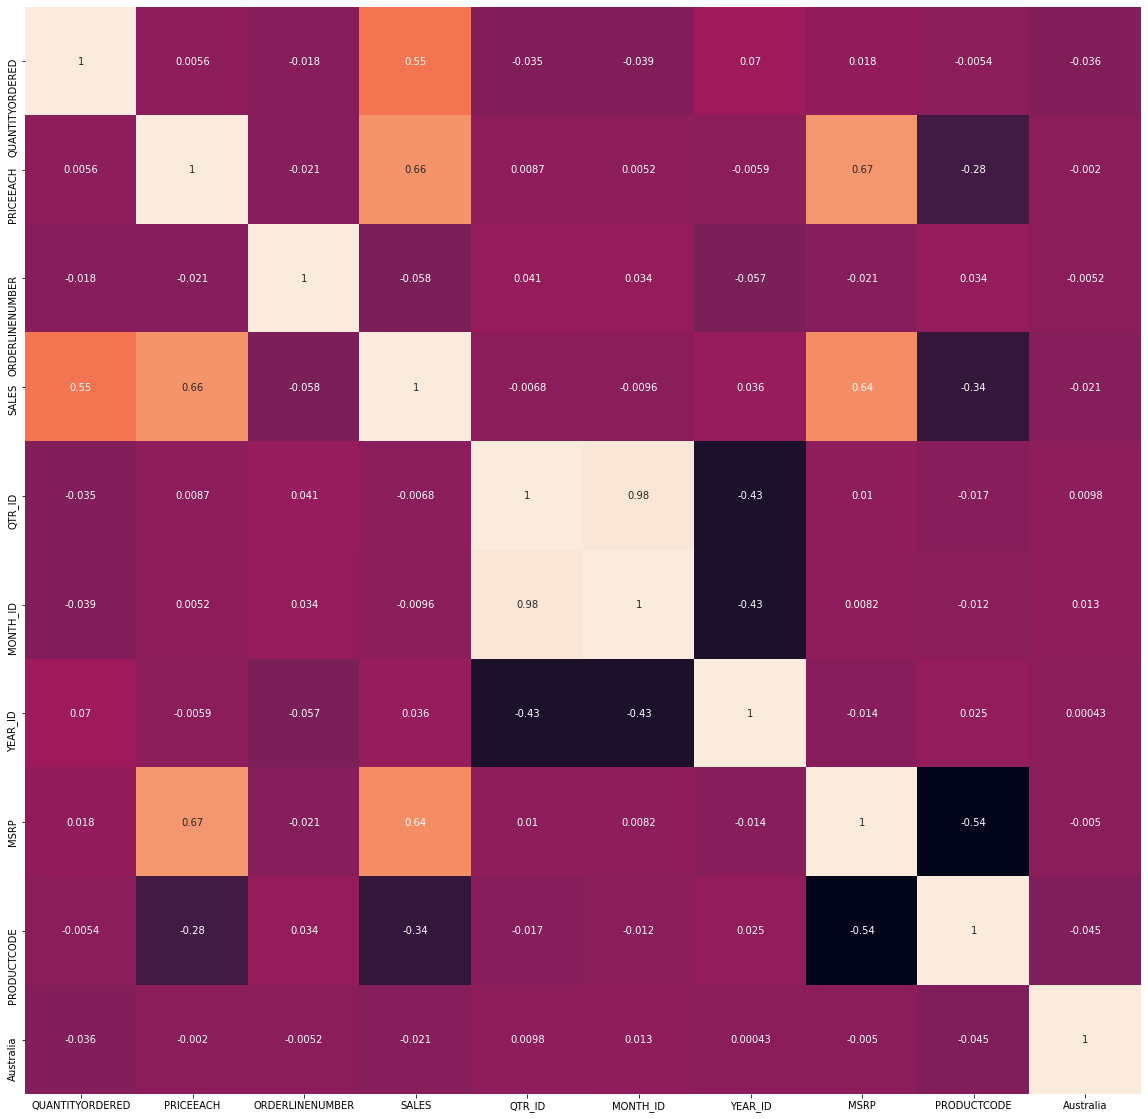

In [37]:
# Getting the correalation matrix:
plt.figure(figsize=(20, 20))
corr_matrix=sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot=True, cbar=False)

In [38]:
# From the heatmap it is seen that month_id and qtr_id are correlated:
# That is why we have to drop any one column: (because high correlation means high similarity).

sales_df.drop('QTR_ID', axis=1, inplace=True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [39]:
# Let's plot distplots
# Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
# (1) Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
# (2) Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
# (3) Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot). 

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()


<Figure size 720x720 with 0 Axes>

In [40]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# A trend exists between 'SALES' and 'QUANTITYORDERED'  
# A trend exists between 'MSRP' and 'PRICEEACH'  
# A trend exists between 'PRICEEACH' and 'SALES'
# It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
# zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph


<Figure size 1080x1080 with 0 Axes>

# Now we are going to use the elbow method to find the optimal number of clusters:

In [41]:
# Scaling the data:
scalar=StandardScaler()
sales_df_scaled=scalar.fit_transform(sales_df)

In [42]:
sales_df_scaled.shape

(2823, 37)

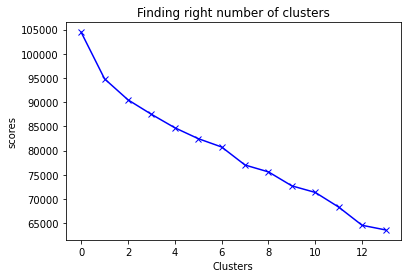

In [43]:
scores=[]
range_values=range(1,15)
for i in range_values:
  kmeans=KMeans(n_clusters=i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_)


plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()


# Now we have to apply KMeans to the data:

In [44]:
# Apply kmeans:
kmeans=KMeans(5)
kmeans.fit(sales_df_scaled)
labels=kmeans.labels_
labels

array([2, 2, 1, ..., 1, 2, 1], dtype=int32)

In [45]:
kmeans.cluster_centers_.shape

(5, 37)

In [46]:
cluster_centers=pd.DataFrame(data=kmeans.cluster_centers_, columns=[sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100
1,0.295705,0.584749,-0.030585,0.462479,-0.003890,-0.002526,0.373086,-0.164077,0.004372,0.021563,-0.000659,0.004921,0.011480,0.017131,0.013311,0.008702,-0.013589,-0.030334,-0.016017,0.014179,0.017108,0.008793,0.034655,0.027167,-0.105371,-0.231843,0.074199,0.060028,0.006329,-0.037221,-0.030936,-0.053324,0.083695,-0.067102,-0.242672,1.019676,-0.912100
2,-0.467973,-0.726828,0.034938,-0.810654,-0.004388,-0.000438,-0.578935,0.281678,0.043961,-0.008757,0.030334,0.032822,-0.004888,0.008244,0.026628,0.008825,0.013012,0.058496,0.035962,0.008495,-0.000773,0.016653,0.020715,-0.001832,-0.105371,-0.231843,0.011793,-0.172256,0.025377,0.070778,0.045788,0.077300,-0.035995,0.091210,-0.242672,-0.980703,1.096370
3,-0.032713,0.191391,0.439377,0.132130,-0.492927,0.264328,0.369955,-0.457595,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,9.490233,-0.231843,-0.742934,1.385402,-0.364452,-0.348674,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,0.438921,-0.328996
4,-0.091667,-0.081269,0.175374,-0.208751,0.281449,-0.184943,-0.147401,0.169580,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,4.313255,-0.742934,-0.029442,-0.209037,-0.004029,0.295213,0.007953,-0.160323,0.119917,-0.242672,0.033775,0.077789


In [47]:
# Now we have to inverse the scaling to read the dataset:
cluster_centers=scalar.inverse_transform(cluster_centers)
cluster_centers=pd.DataFrame(data=cluster_centers, columns=[sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,4.458599e-02,2.547771e-02,-1.908196e-17,6.369427e-03,3.821656e-02,3.184713e-02,1.337580e-01,2.547771e-02,1.273885e-02,4.458599e-02,1.910828e-02,3.184713e-02,6.369427e-03,2.547771e-02,1.082803e-01,1.273885e-02,4.336809e-17,2.547771e-02,4.076433e-01,0.617834,1.210191e-01,5.732484e-02,-1.110223e-16,6.369427e-03,4.458599e-02,1.528662e-01,1.000000e+00,-7.771561e-16,9.992007e-16
1,37.972889,95.453346,6.336948,4405.562990,7.078234,2003.813323,115.706429,48.591789,6.661503e-02,2.246321e-02,1.161890e-02,2.556158e-02,2.401239e-02,3.563129e-02,1.154144e-01,2.323780e-02,4.647560e-03,3.408211e-02,1.626646e-02,3.253292e-02,1.084431e-02,2.943455e-02,1.324555e-01,2.401239e-02,1.890849e-16,1.540434e-15,3.911696e-01,0.371030,1.192874e-01,9.682417e-02,7.436096e-02,1.859024e-02,1.324555e-01,1.874516e-01,-1.873501e-16,1.000000e+00,-8.049117e-15
2,30.534884,68.997907,6.613787,2061.037367,7.076412,2003.814784,77.453488,62.668605,7.641196e-02,1.827243e-02,1.495017e-02,2.990033e-02,2.159468e-02,3.405316e-02,1.196013e-01,2.325581e-02,6.644518e-03,5.149502e-02,2.325581e-02,3.156146e-02,9.136213e-03,3.073090e-02,1.279070e-01,1.993355e-02,1.717376e-16,1.443290e-15,3.612957e-01,0.260797,1.254153e-01,1.303987e-01,9.551495e-02,3.986711e-02,9.551495e-02,2.524917e-01,1.734723e-16,-1.054712e-15,1.000000e+00
3,34.774194,87.519032,8.322581,3797.211613,5.290323,2004.000000,115.580645,39.322581,1.387779e-17,1.040834e-17,-5.204170e-18,6.938894e-18,1.387779e-17,-2.081668e-17,5.551115e-17,1.040834e-17,8.673617e-19,2.081668e-17,-1.040834e-17,-6.938894e-18,-3.469447e-18,-1.387779e-17,2.775558e-17,0.000000e+00,1.000000e+00,-2.775558e-17,5.551115e-17,1.000000,5.551115e-17,-4.163336e-17,1.387779e-17,3.469447e-18,5.551115e-17,-2.775558e-17,4.857226e-17,7.096774e-01,2.903226e-01
4,34.200000,82.019286,7.207143,3169.465857,8.121429,2003.685714,94.792857,59.128571,-9.714451e-17,-5.204170e-17,-2.602085e-17,6.938894e-18,-4.857226e-17,-4.163336e-17,9.714451e-17,-6.938894e-18,-3.469447e-18,9.020562e-17,4.510281e-17,9.367507e-17,-1.040834e-17,-2.428613e-17,-2.636780e-16,1.734723e-17,3.816392e-17,1.000000e+00,5.551115e-16,0.328571,5.000000e-02,1.071429e-01,1.642857e-01,2.857143e-02,5.714286e-02,2.642857e-01,-1.249001e-16,5.071429e-01,4.928571e-01


In [48]:
labels.shape

(2823,)

In [49]:
labels.min()

0

In [50]:
labels.max()

4

In [51]:
sales_df_scaled

array([[-0.52289086,  0.5969775 , -1.05705871, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [-0.11220131, -0.11445035, -0.34701507, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [ 0.60650538,  0.54938372, -1.05705871, ..., -0.24267205,
         1.01967636, -0.9121005 ],
       ...,
       [ 0.81185016,  0.81015797, -0.58369628, ..., -0.24267205,
         1.01967636, -0.9121005 ],
       [-0.11220131, -1.06186404, -1.29373992, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [ 1.2225397 , -0.89925195,  0.59970978, ..., -0.24267205,
         1.01967636, -0.9121005 ]])

In [52]:
y_kmeans=kmeans.fit_predict(sales_df_scaled)
y_kmeans

array([2, 2, 3, ..., 3, 2, 3], dtype=int32)

In [53]:
# Now adding a label for identifying each datapoint to a cluster:
sales_df_cluster=pd.concat([sales_df, pd.DataFrame({'cluster': labels})], axis=1)
sales_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2


In [54]:
# Reducing the original data to 3 dimension for visualizing purpose:
pca=PCA(n_components=3)
principal_comp=pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48632441, -1.16764318,  1.0115225 ],
       [-0.78470094, -1.08856076,  1.38828495],
       [ 1.43139409,  0.09492915,  0.25995602],
       ...,
       [ 0.38979396,  4.09637936, -0.12218226],
       [-2.78888882,  2.35426379,  1.4900724 ],
       [-0.70544215,  3.32356756, -0.51215246]])

In [55]:
pca_df=pd.DataFrame(data=principal_comp, columns=['pca1', 'pca2', 'pca3'])
pca_df

,pca1,pca2,pca3
0,-0.486324,-1.167643,1.011522
1,-0.784701,-1.088561,1.388285
2,1.431394,0.094929,0.259956
3,1.288415,-0.207666,-0.554080
4,1.976046,-0.179477,-1.027418
...,...,...,...
2818,-2.450347,0.986568,-1.608570
2819,-0.158201,3.727887,0.670278
2820,0.389794,4.096379,-0.122182
2821,-2.788889,2.354264,1.490072


In [56]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486324,-1.167643,1.011522,2
1,-0.784701,-1.088561,1.388285,2
2,1.431394,0.094929,0.259956,1
3,1.288415,-0.207666,-0.554080,1
4,1.976046,-0.179477,-1.027418,1
...,...,...,...,...
2818,-2.450347,0.986568,-1.608570,2
2819,-0.158201,3.727887,0.670278,1
2820,0.389794,4.096379,-0.122182,1
2821,-2.788889,2.354264,1.490072,2


In [57]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

# Applying auto-encoders (perform dimensionality reduction using auto encoder).

In [58]:
sales_df.shape

(2823, 37)

In [59]:
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [60]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [69]:
autoencoder.save_weights('autoencoder_1.h5')

In [62]:
pred = encoder.predict(sales_df_scaled)

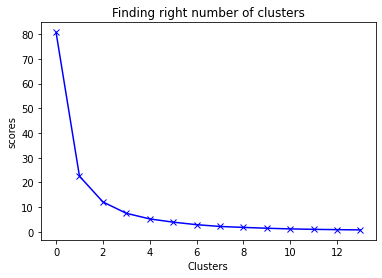

In [63]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [64]:
kmeans = KMeans(5)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [65]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,3
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,3
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,3
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1


In [66]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100
1,0.058284,0.651340,-0.014608,0.502319,0.059458,-0.043319,0.833215,-0.557167,-0.039903,0.114081,-0.039713,-0.028219,0.049880,0.025435,-0.052827,0.128642,-0.001357,-0.128483,-0.054203,0.073508,0.097804,-0.012189,0.009674,0.001542,-0.105371,0.012698,0.012807,1.385402,-0.364452,-0.348674,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,0.904627,-0.796585
2,-0.460643,-0.752561,0.040784,-0.818668,0.006865,-0.017658,-0.632341,0.328988,0.028007,-0.018628,0.026079,0.021762,-0.009361,-0.002159,0.009868,-0.007017,0.010304,0.050458,0.030671,-0.011291,-0.003699,0.010952,-0.001149,-0.017617,-0.105371,0.020662,-0.033163,-0.212823,0.025963,0.086434,0.070231,0.079698,-0.035028,0.107682,-0.242672,-0.980703,1.096370
3,0.405368,0.529322,-0.018322,0.395602,-0.013438,0.018267,0.117383,0.050080,0.009628,-0.047768,0.011079,0.013735,-0.032173,-0.005483,0.018659,-0.069956,-0.028704,0.010847,-0.006364,-0.025447,-0.047382,0.000719,0.016292,0.039600,-0.105371,-0.008314,0.047148,-0.721812,0.203341,0.137219,0.153789,0.019455,0.318480,0.220529,-0.242672,1.019676,-0.912100
4,-0.032713,0.191391,0.439377,0.132130,-0.492927,0.264328,0.369955,-0.457595,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,9.490233,-0.231843,-0.742934,1.385402,-0.364452,-0.348674,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,0.438921,-0.328996


In [68]:
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,4.458599e-02,2.547771e-02,-1.908196e-17,6.369427e-03,3.821656e-02,3.184713e-02,1.337580e-01,2.547771e-02,1.273885e-02,4.458599e-02,1.910828e-02,3.184713e-02,6.369427e-03,2.547771e-02,1.082803e-01,0.012739,4.336809e-17,2.547771e-02,4.076433e-01,6.178344e-01,1.210191e-01,5.732484e-02,-1.110223e-16,6.369427e-03,4.458599e-02,1.528662e-01,1.000000e+00,-7.771561e-16,9.992007e-16
1,35.660482,96.796531,6.404453,4478.929314,7.309833,2003.784787,134.194805,36.178108,5.565863e-02,3.525046e-02,7.421150e-03,2.040816e-02,2.968460e-02,3.710575e-02,9.461967e-02,4.081633e-02,5.565863e-03,1.484230e-02,1.113173e-02,4.267161e-02,1.855288e-02,2.597403e-02,1.243043e-01,0.020408,-8.673617e-17,5.380334e-02,3.617811e-01,1.000000e+00,-1.415534e-15,6.245005e-16,1.054712e-15,1.387779e-16,-8.049117e-16,-2.581269e-15,5.689893e-16,9.424861e-01,5.751391e-02
2,30.606280,68.478857,6.638486,2046.279614,7.117552,2003.802738,75.307568,64.162641,7.246377e-02,1.690821e-02,1.449275e-02,2.818035e-02,2.093398e-02,3.220612e-02,1.143317e-01,2.093398e-02,6.441224e-03,4.991948e-02,2.254428e-02,2.818035e-02,8.856683e-03,2.979066e-02,1.207729e-01,0.017713,1.786765e-16,5.555556e-02,3.397746e-01,2.415459e-01,1.256039e-01,1.352657e-01,1.022544e-01,4.025765e-02,9.581320e-02,2.592593e-01,6.938894e-18,-1.054712e-15,1.000000e+00
3,39.040984,94.335340,6.388759,4282.404977,7.043326,2003.827869,105.432084,55.354801,6.791569e-02,1.288056e-02,1.288056e-02,2.693208e-02,1.756440e-02,3.161593e-02,1.170960e-01,1.170960e-02,3.512881e-03,4.215457e-02,1.756440e-02,2.576112e-02,4.683841e-03,2.810304e-02,1.264637e-01,0.025761,5.551115e-17,4.918033e-02,3.782201e-01,5.273559e-15,1.826698e-01,1.510539e-01,1.252927e-01,3.044496e-02,2.049180e-01,3.056206e-01,8.465451e-16,1.000000e+00,-3.053113e-15
4,34.774194,87.519032,8.322581,3797.211613,5.290323,2004.000000,115.580645,39.322581,1.387779e-17,1.040834e-17,-5.204170e-18,6.938894e-18,1.387779e-17,-2.081668e-17,5.551115e-17,1.040834e-17,8.673617e-19,2.081668e-17,-1.040834e-17,-6.938894e-18,-3.469447e-18,-1.387779e-17,2.775558e-17,0.000000,1.000000e+00,-2.775558e-17,5.551115e-17,1.000000e+00,5.551115e-17,-4.163336e-17,1.387779e-17,3.469447e-18,5.551115e-17,-2.775558e-17,4.857226e-17,7.096774e-01,2.903226e-01
